In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns

%pip install fasttext
import fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached fasttext-0.9.2.tar.gz (68 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3164905 sha256=f0472b98b7b66f6388138894757c1e137e1c3b1af65760e4785785a45a9a0afd
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [2]:
train = pd.read_csv('train.csv')

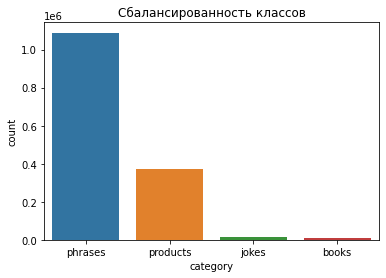

In [3]:
ax = sns.countplot(x=train['category'])
ax.set_title('Сбалансированность классов');

Как видно, в основном присутствуют только классы phrases и products. jokes и books присутствуют в крайне малом количестве

Посмотрим, как выглядит текст в зависимости от его категории

In [5]:
train[train['category'] == 'phrases'][['correct_text', 'corrupted_text']].head(5)

,correct_text,corrupted_text
0,"Считает, что сможет жить вечно!","Считает, что ссожет ить вечно!"
1,20 миллионов и ни пенни меньше!,20 миллионов и ни ппнни меньше!
2,- Но и мы умрём.,- Но и мы умрём.
3,Ты вобще молодец.,Ты вобще молоцд.
4,Вы имеете в виду силу бога?,Вы имеетн в виду силу ьога?


In [6]:
train[train['category'] == 'products'][['correct_text', 'corrupted_text']].head(5)

,correct_text,corrupted_text
7,БоссаНова зефир ванильный темной глазури,босаснов зефир ванильный темной глазури
9,Филип Морис комп Эксперт,Филир Морис комп Эксперт
10,Сигнал заднего хода,Сегнал заднего хода
11,Хлеб Урожайный Куймань,Хлеб Урожайный Куймань
20,Крупа рисовая весовая,Круца рисовая весовая


In [7]:
train[train['category'] == 'jokes'][['correct_text', 'corrupted_text']].head(5)

,correct_text,corrupted_text
121,Я старый больной человек. Тебе 19.,Я старыи больной челaвнк. Тебе 19.
234,"Трое в лодке, нищета и собаки.","Трое в лодкп, нищета и собави."
250,сердце глупца в его языке язык умного в его се...,седрце глупца в егр языке азык умного в его се...
524,"Если женщина не стонет ночью, то она ворчит днем.","Есле женщина не стонет ночтю, то он ворчит днем."
538,где рады там не учащай а где не рады век не бывай,оде рады там не учаща а где не рады век не быва


In [8]:
train[train['category'] == 'books'][['correct_text', 'corrupted_text']].head(5)

,correct_text,corrupted_text
315,"Для него, для мужа, это все-таки легче.","Для рего, для муж, эт все-таки легче."
490,Ведь вы не поступили дурно?,еВдь вы не поступили дурно?
529,"""Ай да квартирка!""","""Ай да квартирка!"""
687,Помещик усмехнулся под белыми усами.,Помещик усмехнулся пaд белыми умами.
718,"-- А мне надо, я обещал.","-- А мге надо, я обещал."


 Возьмем предложения `Ведь вы не поступили дурно?` и `еВдь вы не поступили дурно?`. В данном случае ошибка в том, что местами были перепутаны буквы. 
 
 В примере `Считает, что сможет жить вечно!` и `Считает, что ссожет ить вечно!` присутствует слово с лишней буквой и слово, где одной буквы не хватает.

 Необходимо будет сделать такое решение, которое будет учитывать ошибки подобного типа и исправлять их.

Проверка данных на выбросы:

In [9]:
train.isnull().mean() * 100

corrupted_text    0.0
correct_text      0.0
category          0.0
dtype: float64

Удаляем пунктуацию, переводим текст в нижний регистр и составляем список слов из данной строки

In [ ]:
def remove_punctuation(text):
    punctuation = '''!@#$%^&*(){}[]|._`/?:;"'\,~'''
    for symbol in punctuation:
        if symbol in text:
            text = text.replace(symbol, '')
    return text.strip()

In [ ]:
train['corrupt_text_no_punctuation'] = train.corrupted_text.apply(lambda x: remove_punctuation(x)).apply(lambda x: x.lower())
train['corrupt_text_list'] = train['corrupt_text_no_punctuation'].apply(lambda x: x.split())

In [ ]:
train['correct_text_no_punctuation'] = train.correct_text.apply(lambda x: remove_punctuation(x)).apply(lambda x: x.lower())
train['correct_text_list'] = train['correct_text_no_punctuation'].apply(lambda x: x.split())

Создаем словари для слов в которых были совершены ошибки, для корректных слов и для биграм (словосочетаний по 2 слова)

In [ ]:
bad_words = {} #слова с ошибками
good_words = {} #валидные слова
bigrams = {} #биграммы

In [ ]:
# функция для составления словаря биграмм
def make_bigrams(text):
    for i in range(len(text) - 1):
        bigram = text[i] + ' ' + text[i + 1]
        if bigram in bigrams:
            bigrams[bigram] += 1
        else:
            bigrams[bigram] = 1

'''функция для составления словаря валидных слов, где ключ - слово, 
значение - сколько раз оно встретилось'''      
def make_good_dict(text):
    for word in text:
        if word in good_words:
            good_words[word] += 1
        else:
            good_words[word] = 1

'''функция для составления словаря слов с ошибками (сопоставляет слову 
из текста с ошибками слово на той же позиции из корректного текста)'''          
def make_bad_dict(correct, corrupt):
    for good_word, bad_word in zip(correct, corrupt):
        if good_word != bad_word and good_word in good_words:
            if bad_word in bad_words:
                bad_words[bad_word].add(good_word)
            else:
                bad_words[bad_word] = {good_word}

In [ ]:
train.correct_text_list.apply(lambda x: make_good_dict(x))

0        None
1        None
2        None
3        None
4        None
         ... 
26931    None
26932    None
26933    None
26934    None
26935    None
Name: correct_text_list, Length: 26936, dtype: object

In [ ]:
train.apply(lambda x: make_bad_dict(x.correct_text_list, x.corrupt_text_list), axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
26931    None
26932    None
26933    None
26934    None
26935    None
Length: 26936, dtype: object

In [ ]:
train.correct_text_list.apply(lambda x: make_bigrams(x))

0        None
1        None
2        None
3        None
4        None
         ... 
26931    None
26932    None
26933    None
26934    None
26935    None
Name: correct_text_list, Length: 26936, dtype: object

Используем вероятностный подход для оценки контекста и вероятности употребления данного слова

In [ ]:
'''Сглаженная функция (не переходит в ноль)
   для определения вероятности появления слов'''
def pdist_additive_smoothed(counter, c=1):  #counter - словарь токенов и их частот
    N = sum(list(counter.values()))          # суммарное кол-во слов
    Nplus = N + c * (len(counter) + 1) # кол-во слов + сглаживание
    return lambda word: (counter[word] + c) / Nplus 

P1 = pdist_additive_smoothed(good_words)
P2 = pdist_additive_smoothed(bigrams)

# функция для перемножения вероятностей
def product(nums):
    result = 1
    for x in nums:
        result *= x
    return result

In [ ]:
# вероятность последовательности слов с помощью биграммной модели (при условии предыдущего слова)
def Pwords2(words, prev=''):
    return product(cPword(w, (prev if (i == 0) else words[i-1]) )
                   for (i, w) in enumerate(words))

# условная вероятность слова при условии предыдущего
def cPword(word, prev):
    "Условная вероятность слова при условии предыдущего."
    bigram = prev + ' ' + word
    if bigram in bigrams and prev in good_words:
        return P2(bigram) / P1(prev)
    else: # если что-то не встретилось, поставим среднее между P1 и 0
        return P1(word) / 2

Определяем возможные валидные слова на edit distance 0, 1 и 2 от нашего слова

In [ ]:
''' функция возвращает подмножество слов, которое есть в нашем словаре с частотой более 10 
(т.к в валидном тексте были замечены некорректные слова с маленькой частотой)''' 
def known(words):
    res = set()
    for w in words:
        if w in good_words.keys() and good_words[w] > 10:
            res.add(w)
    return res

# все строки, которые находятся на edit_distance == 0 от word (т.е само слово)
def edits0(word):
    return {word}

# все строки, которые находятся на edit_distance == 2 от word
def edits2(word):   
    return {e2 for e1 in edits1(word) for e2 in edits1(e1)}

In [ ]:
# возвращает список всех строк на расстоянии edit_distance == 1 от word
def edits1(word):
    pairs      = splits(word)
    deletes    = [a+b[1:]           for (a, b) in pairs if b]
    transposes = [a+b[1]+b[0]+b[2:] for (a, b) in pairs if len(b) > 1]
    replaces   = [a+c+b[1:]         for (a, b) in pairs for c in alphabet if b]
    inserts    = [a+c+b             for (a, b) in pairs for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

# список всех возможных разбиений слова на пару (a, b)
def splits(word):
    return [(word[:i], word[i:]) 
            for i in range(len(word)+1)]

# включили - в алфавит, т.к есть слова по типу "какой-то", "посмтри-ка"
alphabet = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя-' 

Осуществляем исправления слов. 
Сначала прямолинейным подходом - ищем в словаре неправильных слов замену (если несколько вариантов исправления, выбираем самый подходящий по биграммам или вероятности появления данного слова).
Далее пользуемся подходом Норвига (вышенаписанные функции) с изменением неправильного слова на расстояния 1 и 2 (если получилось несколько кандидатов также смотрим по биграммам и вероятностям слов)

In [ ]:
# поиск наиболее вероятной биграммы
def find_best_b(bi):
    best_P = 0
    for b in bi:
        if Pwords2(b) >= best_P:
            best_P = Pwords2(b)
            best_bi = b
    return best_bi

In [ ]:
# реализация прямолинейного подхода
def checker(text_check):
    text = text_check.copy()
    for i in range(len(text)):
        ''' ищем слова которые были исправлены в train и не содержатся в словаре валидных слов
        (чтобы случайно не исправить правильные слова)''' 
        if text[i] in bad_words and (text[i] not in good_words or good_words[text[i]] < 100):
            candidates = bad_words[text[i]]
            # если предыдущее слово - валидное, составляем с ним биграммы
            if i != 0 and text[i - 1] in good_words: 
                bi = []
                for candidate in candidates:
                    bi.append([text[i - 1], candidate])
                
                best_bi = find_best_b(bi)
                text[i] = best_bi[1]
            # если предыдущее слово - не валидное, смотрим по вероятности текущего слова    
            else:
                text[i] = (max(bad_words[text[i]], key=P1))
                
    return text

In [ ]:
# реализация подхода с исправлением опечаток на расстоянии 1 и 2
def checker2(text_check):
    text = text_check.copy()
    for i in range(len(text)):
        # используем только для некорректных слов
        if text[i] not in good_words:
            # выбираем кандидатов с помощью написанных выше функций
            candidates = (known(edits1(text[i])) or known(edits2(text[i])))
            if not candidates:
                continue
            if i != 0 and text[i - 1] in good_words and len(text[i]) > 3:
                bi = []
                for candidate in candidates:
                    bi.append([text[i - 1], candidate])
                best_bi = find_best_b(bi)
                text[i] = best_bi[1]
            else:
                text[i] = max(candidates, key=good_words.get)

    return text

Подготавливаем тестовые данные

In [ ]:
test = pd.read_csv('private_test.csv') # необходимо указать файл

In [ ]:
test['corrupt_text_no_punctuation'] = test.corrupted_text.apply(lambda x: remove_punctuation(x)).apply(lambda x: x.lower())

In [ ]:
test['list_text'] = test['corrupt_text_no_punctuation'].apply(lambda x: x.split())

In [ ]:
test['good_text'] = test['list_text'].apply(lambda x: checker(x))

In [29]:
%%time
test['good_text'] = test['good_text'].apply(lambda x: checker2(x))

KeyboardInterrupt: ignored

In [ ]:
# функция для восстановления пунктуации и заглавных букв с помощью исходного текста
def restore_punctuation(original_text, good_text):
    res = []
    punctuation = '''!@#$%^&*(){}[]|._`/?:;"'\,~'''
    for orig_word, word in zip(original_text, good_text):
        if orig_word[-1] in punctuation:
            word = word + orig_word[-1]
        if orig_word[0] in punctuation:
            word = orig_word[0] + word
        if (orig_word == '-' or orig_word == '—') and word == 'я':
            word = orig_word
        if orig_word.istitle():
            word = word[0].upper() + word[1:]
        res.append(word)
    return ' '.join(res)

In [ ]:
test['corrupt_text_list'] = test['corrupted_text'].apply(lambda x: x.split())

In [ ]:
test['res'] = test.apply(lambda x: restore_punctuation(x.corrupt_text_list, x.good_text), axis=1)

In [ ]:
test.res.to_csv('res3.csv', index=False)

## FastText

Используем FastText для классификации тестовых данных на 4 категории из train датасета

In [10]:
train['correct_text_edited'] = '__label__' + train['category'] + ' ' + train['correct_text']
train['correct_text_edited'] = train['correct_text_edited'].apply(lambda x: x.lower())

In [11]:
train['correct_text_edited'].to_csv('correct_text_edited.txt', index=False)

In [ ]:
import fasttext
model = fasttext.train_supervised(input='correct_text_edited.txt', epoch=25, wordNgrams=2)

In [ ]:
def get_pred(words):
    return model.predict(words)[0][0]

In [ ]:
test['category'] = test['corrupted_text'].apply(get_pred)
test['category'].value_counts()

Используем FastText для составления эмбеддингов, основанных на последовательности символов, чтобы далее искать ближайшие слова - кандидаты для исправления

Т.к в категории продуктов слова специфичные и отличаются от общих слов в фразах и других категориях, отдельно обучаемся на текстах из разных категорий

In [ ]:
train['correct_text'] = train['correct_text'].apply(lambda x: x.lower())

In [ ]:
train[train['category'] == 'phrases']['correct_text'].to_csv('category_text.txt', index=False)

In [ ]:
model_phrases = fasttext.train_unsupervised('category_text.txt', 
                                    wordNgrams=1, 
                                    minn=1, 
                                    maxn=2, 
                                    dim=300, 
                                    ws=8, 
                                    neg=8, 
                                    epoch=10, 
                                    minCount=10, 
                                    bucket=900000)

In [ ]:
train[train['category'] == 'products']['correct_text'].to_csv('correct_category.txt', index=False)

In [ ]:
model_products = fasttext.train_unsupervised('correct_category.txt', 
                                    wordNgrams=1, 
                                    minn=1, 
                                    maxn=2, 
                                    dim=300, 
                                    ws=8, 
                                    neg=8, 
                                    epoch=10, 
                                    minCount=10, 
                                    bucket=900000)

In [ ]:
public_df = pd.read_csv('res3.csv')

In [ ]:
test

In [ ]:
public_df['category'] = public_df['res'].apply(get_pred)

In [ ]:
def product_checker(text_check):
    text = text_check.copy()
    for i in range(len(text)):
        if text[i] not in good_words:
            candidates = [x[1] for x in model_products.get_nearest_neighbors(text[i], k=10)]
            for candidate in candidates:
                if len(candidate) >= len(text[i]):
                    text[i] = candidate
                    break
    return text

In [ ]:
def not_product_checker(text_check):
    text = text_check.copy()
    for i in range(len(text)):
        if text[i] not in good_words:
                candidates = [x[1] for x in model_phrases.get_nearest_neighbors(text[i], k=10)]
                for candidate in candidates:
                    if len(candidate) >= len(text[i]):
                        text[i] = candidate
                        break
    return text

In [ ]:
public_df['corrupt_text_no_punctuation'] = public_df.res.apply(lambda x: remove_punctuation(x)).apply(lambda x: x.lower())

In [ ]:
public_df['list_text'] = public_df['corrupt_text_no_punctuation'].apply(lambda x: x.split())

In [ ]:
public_df.loc[public_df['category'] == '__label__products', 'list_text'] = public_df[public_df['category'] == '__label__products']['list_text'].apply(lambda x: product_checker(x))

In [ ]:
public_df.loc[public_df['category'] != '__label__products', 'list_text'] = public_df[public_df['category'] != '__label__products']['list_text'].apply(lambda x: not_product_checker(x))

In [ ]:
public_df['corrupt_text_list'] = public_df['res'].apply(lambda x: x.split())
public_df['final_res'] = public_df.apply(lambda x: restore_punctuation(x.corrupt_text_list, x.list_text), axis=1)

In [ ]:
public_df.final_res.to_csv('1res_private.csv', index=False)